In [1]:
import time

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np

from stabnode.node import FTerm, GTerm, set_global_seed, StabNODE
from data.hysteresis import simulate_steady_state
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
seed = 1234
set_global_seed(seed = seed)

# Simple hysteresis learning

In [3]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

In [4]:
x0=-1

simulate_time = (0.,50.)

x_increase = simulate_steady_state(lam_increase, x0, simulate_time)
x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

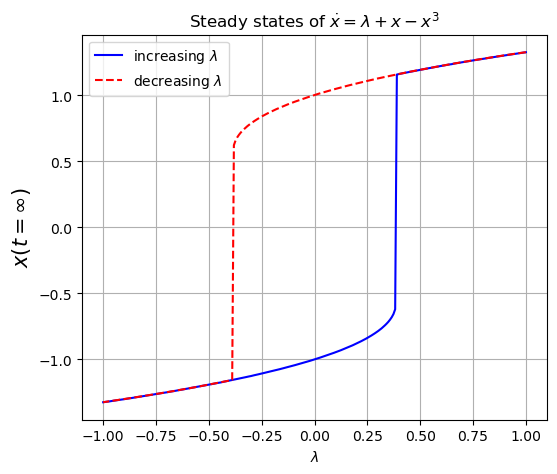

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_increase, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_decrease, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

# Stabnode learning

In [6]:
X = np.hstack((x_increase, x_decrease))
lam = np.hstack((lam_increase, lam_decrease))
repeat = 2

for _ in range(repeat):
    X = np.hstack((X,X))
    lam = np.hstack((lam, lam))

tau = torch.arange(0,len(lam),device=device)
t = (tau+1)*simulate_time[-1]

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X.reshape(-1,1))
X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
scaler.data_max_, scaler.data_min_

(array([1.32443915]), array([-1.32455021]))

In [8]:
sample_rate = 1
tau_train = tau[::sample_rate]
X_train = X_scaled[tau_train]
lam_train = lam[tau_train]

In [34]:
tau_train.shape

torch.Size([2000])

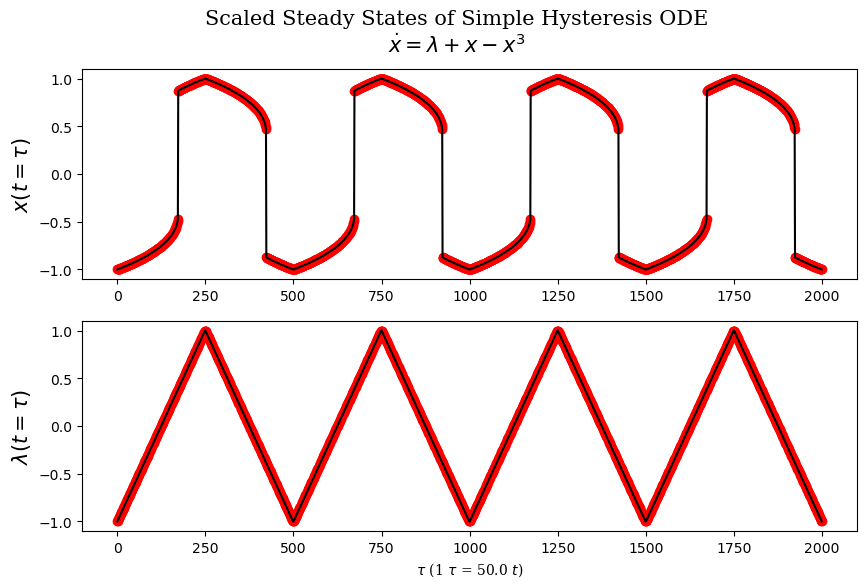

In [9]:
fig, ax = plt.subplots(2,1, figsize = (10,6))
color = 'black'

ax[0].plot(tau, X_scaled,c=color, label='True')
ax[0].scatter(tau_train, X_train,c='red', label='measurements')
ax[0].set_ylabel(r"$x(t = \tau)$",size=15, family='serif')

ax[1].plot(tau, lam,c=color)
ax[1].scatter(tau_train, lam_train,c='red')
ax[1].set_xlabel(fr"$\tau$ (1 $\tau$ = {simulate_time[-1]:.1f} $t$)",family='serif')
ax[1].set_ylabel(fr"$\lambda (t = \tau)$", family = 'serif', size=15)
plt.suptitle("Scaled Steady States of Simple Hysteresis ODE\n"+r"$\dot{x} = \lambda +x-x^3$",family='serif', size=15)
plt.show()

In [10]:
def lam_func(tau):
    idx = int(tau) % len(lam)
    return torch.tensor(lam[idx],dtype=torch.float32, device=device)

In [11]:
dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]
hidden_dim = 2

f = FTerm(dim_in, dim_out, hidden_dim )
g = GTerm(dim_in+1, dim_out, hidden_dim)

stab_node = StabNODE(f,g)
stab_node

StabNODE(
  (f): FTerm(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
  (g): GTerm(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [12]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 1e-2)

# early stopping criteria 
patience = ...
rtol = ...
print_every = 10

tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32, device=device)

n_epochs = 250
losses = []
for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method='rk4')
    loss = loss_criteria(x_pred.squeeze(), X_train.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    losses.append(loss.item())
    if epoch <= 5 or epoch % print_every == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1:.4f} s.")
    

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: Loss = 0.7915, time = 3.7457 s.
Epoch 1: Loss = 0.7743, time = 3.9339 s.
Epoch 2: Loss = 0.7581, time = 4.2013 s.
Epoch 3: Loss = 0.7426, time = 4.0928 s.
Epoch 4: Loss = 0.7280, time = 4.2646 s.
Epoch 5: Loss = 0.7142, time = 4.1359 s.
Epoch 10: Loss = 0.6541, time = 4.2780 s.
Epoch 20: Loss = 0.5571, time = 4.1348 s.
Epoch 30: Loss = 0.4649, time = 4.2855 s.
Epoch 40: Loss = 0.3765, time = 4.1281 s.
Epoch 50: Loss = 0.3011, time = 4.2792 s.
Epoch 60: Loss = 0.2539, time = 4.2833 s.
Epoch 70: Loss = 0.2320, time = 4.1262 s.
Epoch 80: Loss = 0.2160, time = 4.2719 s.
Epoch 90: Loss = 0.1688, time = 4.1107 s.
Epoch 100: Loss = 0.0136, time = 4.2199 s.
Epoch 110: Loss = 0.0130, time = 4.1791 s.
Epoch 120: Loss = 0.0100, time = 4.0488 s.
Epoch 130: Loss = 0.0102, time = 4.1390 s.
Epoch 140: Loss = 0.0099, time = 3.9756 s.
Epoch 150: Loss = 0.0097, time = 4.1191 s.
Epoch 160: Loss = 0.0095, time = 4.1148 s.
Epoch 170: Loss = 0.0093, time = 3.9826 s.
Epoch 180: Loss = 0.0092, time =

In [13]:
# losses

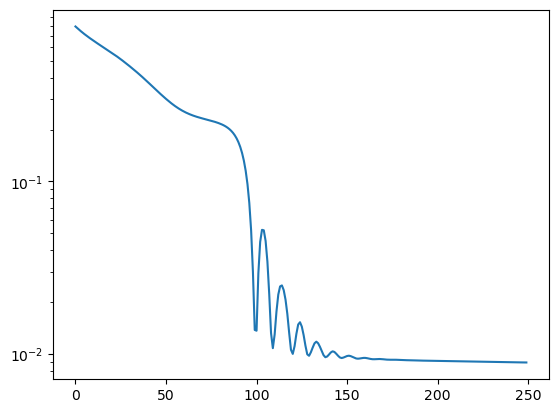

In [14]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [15]:
losses = np.array(losses)

In [16]:
losses[-10:]

array([0.00894978, 0.00894681, 0.00894387, 0.00894096, 0.00893807,
       0.00893523, 0.00893242, 0.00892966, 0.00892692, 0.00892422])

In [17]:
loss_diff = losses[1:] - losses[:-1]

In [18]:
loss_diff[-50:].min()

-5.236826837062836e-06

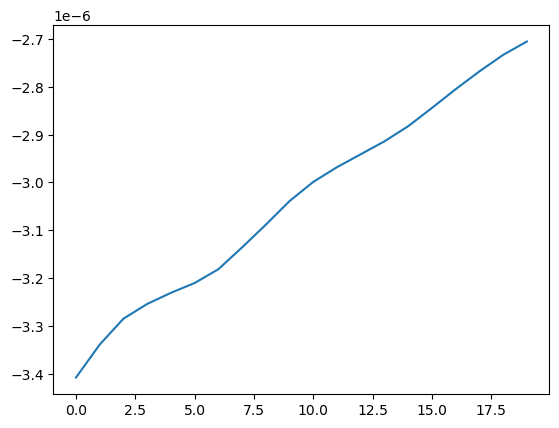

In [19]:
plt.plot(loss_diff[-20:])

# g and f outputs

In [20]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [21]:
g.eval()
f.eval()


g_true_out = []
g_pred_out = []

f_true_out = []
f_pred_out = []

for tau_i in tau:

    lam_i = lam_func(tau_i).reshape(-1,1)
    xi = X_scaled[tau_i].reshape(-1,1)
    xi_unscaled = X[tau_i].reshape(-1,1)

    g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
    f_true_out.append(f_true(xi_unscaled))

    with torch.no_grad():
        g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
        f_pred_out.append(f(xi).detach().cpu().numpy())

g_true_out = np.array(g_true_out).reshape(-1)
g_pred_out = np.array(g_pred_out).reshape(-1)

f_true_out = np.array(f_true_out).reshape(-1)
f_pred_out = np.array(f_pred_out).reshape(-1)
    

In [22]:
finite_idx = np.isfinite(g_true_out)
np.count_nonzero(~finite_idx)

0

In [23]:
g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

In [24]:
g_pred_out[0], x0

(-0.9219198, tensor([[-1.]]))

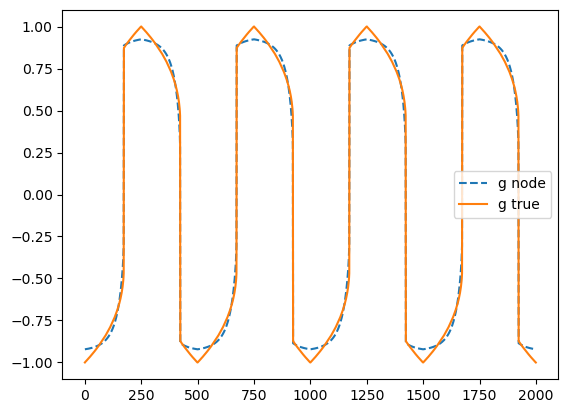

In [36]:
plt.plot(g_pred_out, linestyle='--', label='g node')
plt.plot(g_true_scaled, label='g true')
# plt.plot(X_scaled, label='raw data')
plt.legend()
plt.show()

In [26]:
x0, tau_train[0]

(tensor([[-1.]]), tensor(0))

In [27]:
X_scaled[:10]

tensor([[-1.0000],
        [-0.9988],
        [-0.9975],
        [-0.9962],
        [-0.9948],
        [-0.9931],
        [-0.9916],
        [-0.9903],
        [-0.9891],
        [-0.9873]])

In [28]:
scaler.data_max_

array([1.32443915])

In [29]:
g_true_out.max()

1.325790317927218

In [30]:
f_true_scaled = scaler.transform(f_true_out.reshape(-1,1)).reshape(-1)

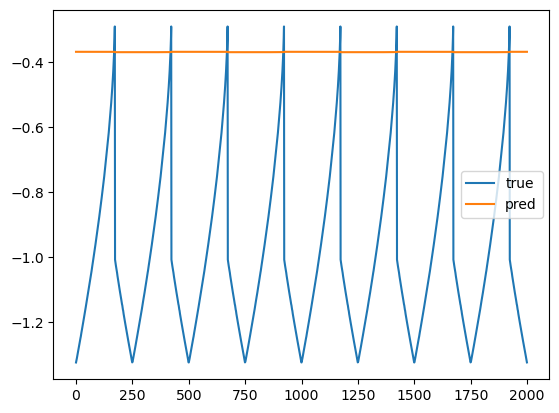

In [31]:
plt.plot(f_true_scaled,label='true')
plt.plot(f_pred_out, label='pred')
plt.legend()
plt.show()

In [32]:
X_train[0].numpy()

array([-1.], dtype=float32)

In [33]:
X_scaled[0]

tensor([-1.])